In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataframe = pd.read_csv("cleaned_dataset_with_enhanced_news_source_and_author_credibility_scores.csv")

In [14]:
print(f"Dataset shape: {dataframe.shape}")
dataframe.head()

Dataset shape: (2035, 16)


,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage,enhanced_source_credibility_score,enhanced_author_credibility_score,title_length,text_length
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0,95.28177,85.755236,51,492
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0,95.28177,82.226429,57,1720
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0,95.28177,85.755236,67,1323
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0,95.28177,88.238767,115,262
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0,95.28177,88.238767,90,2047


In [40]:
language_counts = dataframe["language"].value_counts()
print(language_counts)

language
english    1957
german       72
ignore        3
french        2
spanish       1
Name: count, dtype: int64


In [41]:
# Print one example of a news row where the language is 'german'
german_news_example = dataframe[dataframe["language"] == "german"].head(1)
print(german_news_example)

        author                      published  \
925  No Author  2016-11-23T12:44:09.173+02:00   

                                              title  \
925  sparks fly as bikers for trump meet protesters   

                                                  text language  \
925  umfrage ceta würde enorm an zustimmung gewinne...   german   

              site_url                                       main_img_url  \
925  der-postillon.com  https://1.bp.blogspot.com/-fX3NNr8NmaE/Uci9s8r...   

    type label                            title_without_stopwords  ...  \
925   bs  Fake  weil sie sich prügelten gefängnisdirektor erte...  ...   

    title_length_of_characters_zscore  title_word_count_zscore  \
925                         -0.487954                -0.389929   

     text_length_of_characters_zscore  text_word_count_zscore  \
925                         -0.203667               -0.296677   

     title_average_word_length_zscore  text_average_word_length_zscore  \
925          

In [15]:
# 1. Basic Length Analysis

# 1.1 Calculate various length metrics for titles and text
# Character count - including spaces
dataframe["title_length_of_characters"] = dataframe["title"].apply(lambda x: len(x) if isinstance(x, str) else 0)
dataframe["text_length_of_characters"] = dataframe["text"].apply(lambda x: len(x) if isinstance(x, str) else 0)

In [16]:
# Word count
dataframe["title_word_count"] = dataframe["title"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
dataframe["text_word_count"] = dataframe["text"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

In [17]:
# Average word length in title and text
# This is a linguistic style indicator 
def calculate_average_word_length(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # \b – Word boundary: Matching the position where a word starts or ends.
    # \w+ – One or more word characters
    # \w matches any alphanumeric character and underscore: [A-Za-z0-9_]
    # (?:'\w+)? – Optional contraction part:
    # (?:...) is a non-capturing group — it groups the pattern without saving it separately.
    # '\w+ matches an apostrophe followed by letters (e.g., 's, 't, 've).
    # ? makes this whole group optional, so it matches both "dog" and "dog's"
    words = re.findall(r"\b\w+(?:'\w+)?\b", text.lower())
    if not words:
        return 0
    return sum(len(word) for word in words) / len(words)

dataframe["title_average_word_length"] = dataframe["title"].apply(calculate_average_word_length)
dataframe["text_average_word_length"] = dataframe["text"].apply(calculate_average_word_length)

In [18]:
# 1.2 Calculate sentence-based metrics for text content
# These are structural unit metrics
def count_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Simple sentence counting by splitting on common sentence terminators
    # [.!?] – A character class that matches any one of the characters inside the brackets
    # +: A quantifier meaning "one or more", [.!?]+ matches any combination like ..., !?, ?!, etc.
    sentences = re.split(r'[.!?]+', text)
    # Filter out empty strings
    return len([s for s in sentences if s.strip()])

dataframe["text_sentence_count"] = dataframe["text"].apply(count_sentences)

In [19]:
# Calculate average sentence length (ASL) 
dataframe["text_average_sentence_length"] = dataframe.apply(
    lambda row: row["text_word_count"] / row["text_sentence_count"] if row["text_sentence_count"] > 0 else 0, 
    axis=1
)

In [20]:
# Calculate sentence length variance as mentioned in Section III.A
def sentence_length_variance(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    sentences = [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]
    # If there's only one or zero sentences, variance could not be calculated
    if len(sentences) <= 1:
        return 0
    # s.split() splits each sentence into words (using whitespace).
    # len(s.split()) gives the number of words in the sentence
    sentence_lengths = [len(s.split()) for s in sentences]
    # np.var(sent_lengths): Calculates the population variance σ2 of the sentence lengths using NumPy
    return np.var(sentence_lengths) if sentence_lengths else 0

dataframe["text_sentence_length_variance"] = dataframe["text"].apply(sentence_length_variance)

In [21]:
# 1.3 Create a title-content length ratio 
# This measures the relationship between title length and content length
dataframe["title_to_content_length_ratio"] = dataframe.apply(
    lambda row: row["title_word_count"] / row["text_word_count"] if row["text_word_count"] > 0 else 0,
    axis=1
)

In [22]:
# 2. Compare length metrics between real and fake news

# Split dataset by label
real_news = dataframe[dataframe["label"] == "Real"]
fake_news = dataframe[dataframe["label"] == "Fake"]

In [23]:
# 2.1 Compare basic title and content length metrics
print("\n--- Basic Length Comparison ---")
print(f"Average Title Length (by characters) - Real News: {real_news['title_length_of_characters'].mean():.2f}")
print(f"Average Title Length (by characters) - Fake News: {fake_news['title_length_of_characters'].mean():.2f}")

print(f"Average Title Word Count - Real News: {real_news['title_word_count'].mean():.2f}")
print(f"Average Title Word Count - Fake News: {fake_news['title_word_count'].mean():.2f}")

print(f"Average Text Length (by characters) - Real News: {real_news['text_length_of_characters'].mean():.2f}")
print(f"Average Text Length (by characters) - Fake News: {fake_news['text_length_of_characters'].mean():.2f}")

print(f"Average Text Word Count - Real News: {real_news['text_word_count'].mean():.2f}")
print(f"Average Text Word Count - Fake News: {fake_news['text_word_count'].mean():.2f}")


--- Basic Length Comparison ---
Average Title Length (by characters) - Real News: 56.67
Average Title Length (by characters) - Fake News: 65.07
Average Title Word Count - Real News: 9.25
Average Title Word Count - Fake News: 10.56
Average Text Length (by characters) - Real News: 3209.14
Average Text Length (by characters) - Fake News: 2843.22
Average Text Word Count - Real News: 542.41
Average Text Word Count - Fake News: 469.07


In [24]:
# 2.2 Compare linguistic style metrics
print("\n--- Linguistic Style Comparison ---")
print(f"Average Word Length in Title - Real News: {real_news['title_average_word_length'].mean():.2f}")
print(f"Average Word Length in Title - Fake News: {fake_news['title_average_word_length'].mean():.2f}")

print(f"Average Word Length in Text - Real News: {real_news['text_average_word_length'].mean():.2f}")
print(f"Average Word Length in Text - Fake News: {fake_news['text_average_word_length'].mean():.2f}")

print(f"Average Sentence Count - Real News: {real_news['text_sentence_count'].mean():.2f}")
print(f"Average Sentence Count - Fake News: {fake_news['text_sentence_count'].mean():.2f}")

print(f"Average Sentence Length - Real News: {real_news['text_average_sentence_length'].mean():.2f}")
print(f"Average Sentence Length - Fake News: {fake_news['text_average_sentence_length'].mean():.2f}")

print(f"Average Sentence Length Variance - Real News: {real_news['text_sentence_length_variance'].mean():.2f}")
print(f"Average Sentence Length Variance - Fake News: {fake_news['text_sentence_length_variance'].mean():.2f}")

print(f"Average Title-to-Content Ratio - Real News: {real_news['title_to_content_length_ratio'].mean():.4f}")
print(f"Average Title-to-Content Ratio - Fake News: {fake_news['title_to_content_length_ratio'].mean():.4f}")


--- Linguistic Style Comparison ---
Average Word Length in Title - Real News: 5.20
Average Word Length in Title - Fake News: 5.27
Average Word Length in Text - Real News: 4.93
Average Word Length in Text - Fake News: 5.18
Average Sentence Count - Real News: 1.02
Average Sentence Count - Fake News: 1.01
Average Sentence Length - Real News: 530.47
Average Sentence Length - Fake News: 464.62
Average Sentence Length Variance - Real News: 4301.25
Average Sentence Length Variance - Fake News: 2279.40
Average Title-to-Content Ratio - Real News: 0.1218
Average Title-to-Content Ratio - Fake News: 0.1789


In [25]:
# 3. Statistical significance testing
# Test if the differences in length metrics are statistically significant
print("\n--- Statistical Significance Tests ---")

# Function to perform t-test and report results
def test_significance(real_metric, fake_metric, metric_name):
    # Perform independent samples t-test
    # Uses scipy.stats.ttest_ind to run a two-sample t-test.
    # Welch's t-test is more robust when the two groups have unequal variances or sample sizes
    # The t-statistic (strength of evidence)
    # The p-value (probability of observing this difference by random chance)
    t_statistic, p_value = stats.ttest_ind(
        # Remove NaN values that might otherwise invalidate the t-test
        real_metric.dropna(), 
        fake_metric.dropna(), 
        equal_var=False  # Use Welch's t-test which doesn't assume equal variances
    )
    significance_result = "Significant" if p_value < 0.05 else "Not significant"
    print(f"The statistical significance testing for '{metric_name}': t_statistic={t_statistic:.2f}, p_value={p_value:.4f}, significance result={significance_result}")
    return p_value < 0.05


--- Statistical Significance Tests ---


In [26]:
# Test each metric
metrics = [
    ('title_length_of_characters', 'Title Length (by characters)'),
    ('title_word_count', 'Title Word Count'),
    ('text_length_of_characters', 'Text Length (by characters)'),
    ('text_word_count', 'Text Word Count'),
    ('title_average_word_length', 'Title Average Word Length'),
    ('text_average_word_length', 'Text Average Word Length'),
    ('text_sentence_count', 'Text Sentence Count'),
    ('text_average_sentence_length', 'Text Average Sentence Length'),
    ('text_sentence_length_variance', 'Text Sentence Length Variance'),
    ('title_to_content_length_ratio', 'Title-to-Content Word Count Ratio')
]

In [27]:
significant_metrics = []
for metric, name in metrics:
    if test_significance(real_news[metric], fake_news[metric], name):
        significant_metrics.append((metric, name))

The statistical significance testing for 'Title Length (by characters)': t_statistic=-5.91, p_value=0.0000, significance result=Significant
The statistical significance testing for 'Title Word Count': t_statistic=-5.72, p_value=0.0000, significance result=Significant
The statistical significance testing for 'Text Length (by characters)': t_statistic=2.02, p_value=0.0432, significance result=Significant
The statistical significance testing for 'Text Word Count': t_statistic=2.38, p_value=0.0175, significance result=Significant
The statistical significance testing for 'Title Average Word Length': t_statistic=-1.20, p_value=0.2293, significance result=Not significant
The statistical significance testing for 'Text Average Word Length': t_statistic=-6.90, p_value=0.0000, significance result=Significant
The statistical significance testing for 'Text Sentence Count': t_statistic=0.86, p_value=0.3898, significance result=Not significant
The statistical significance testing for 'Text Average Se

In [28]:
# Print the list of significant metrics
print("\nMetrics with statistically significant differences between real and fake news:")
for metric, name in significant_metrics:
    print(f"- {name} - (column: '{metric}')")


Metrics with statistically significant differences between real and fake news:
- Title Length (by characters) - (column: 'title_length_of_characters')
- Title Word Count - (column: 'title_word_count')
- Text Length (by characters) - (column: 'text_length_of_characters')
- Text Word Count - (column: 'text_word_count')
- Text Average Word Length - (column: 'text_average_word_length')
- Text Average Sentence Length - (column: 'text_average_sentence_length')


<Figure size 1400x700 with 0 Axes>

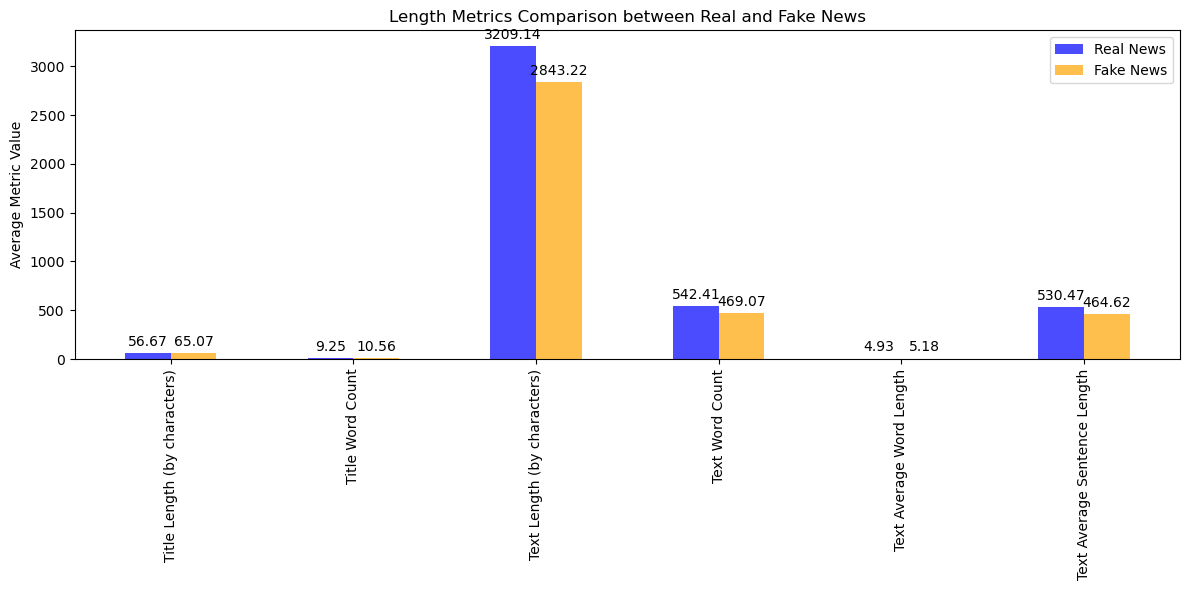

In [31]:
# 4. Visualizations
# 4.1 Bar chart comparing key metrics between real and fake news
plt.figure(figsize=(14, 7))
# Select top metrics to visualize
metrics_to_visualize = ['title_length_of_characters', 'title_word_count', 'text_length_of_characters', 'text_word_count', 'text_average_word_length', 'text_average_sentence_length']
labels = ['Title Length (by characters)', 'Title Word Count', 'Text Length (by characters)', 'Text Word Count', 'Text Average Word Length', 'Text Average Sentence Length']

real_metric_average_values = [real_news[metric].mean() for metric in metrics_to_visualize]
fake_metric_average_values = [fake_news[metric].mean() for metric in metrics_to_visualize]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, real_metric_average_values, width, label='Real News', color='blue', alpha=0.7)
rects2 = ax.bar(x + width/2, fake_metric_average_values, width, label='Fake News', color='orange', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Metric Value')
ax.set_title('Length Metrics Comparison between Real and Fake News')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


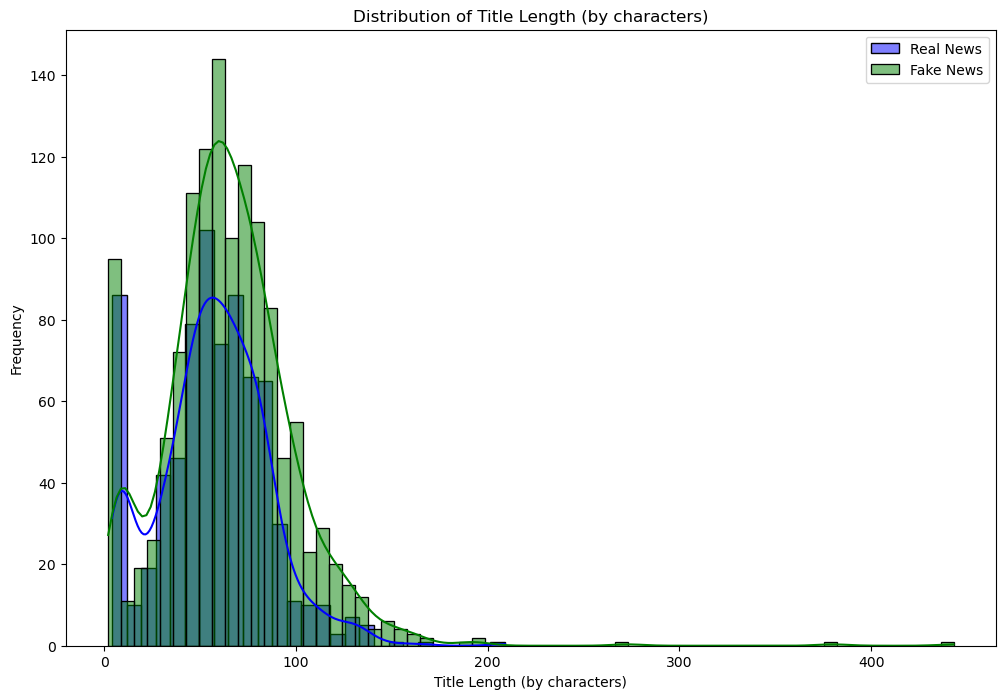

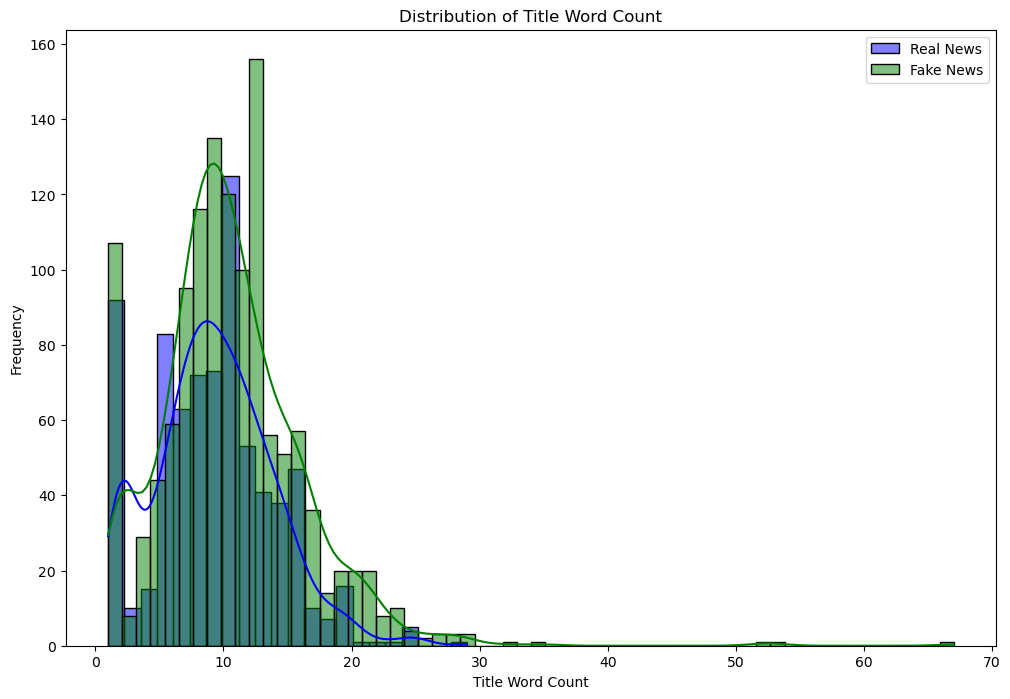

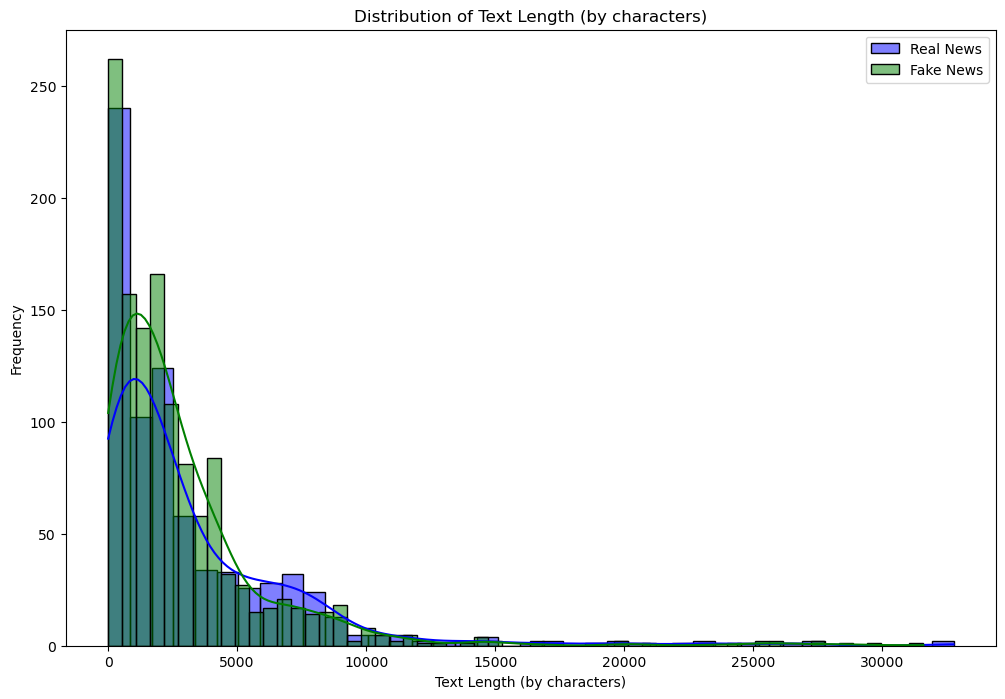

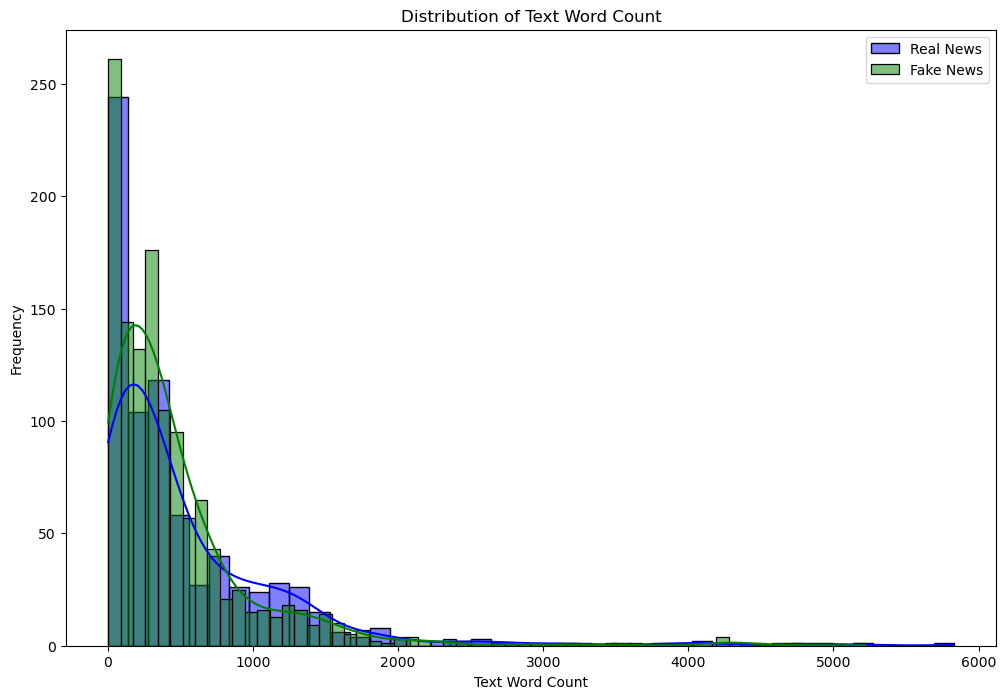

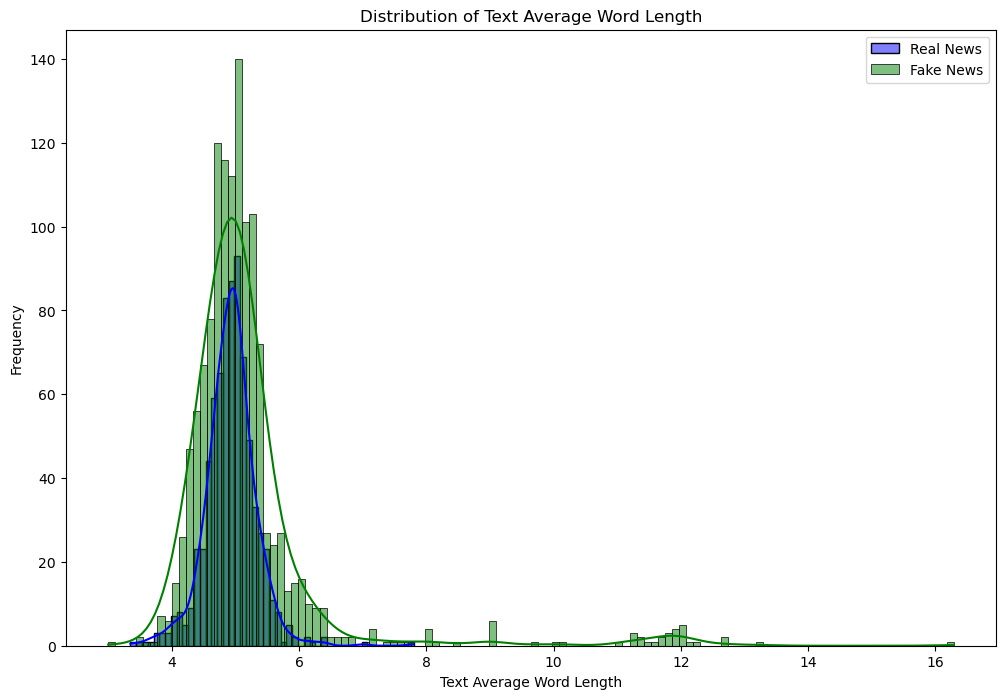

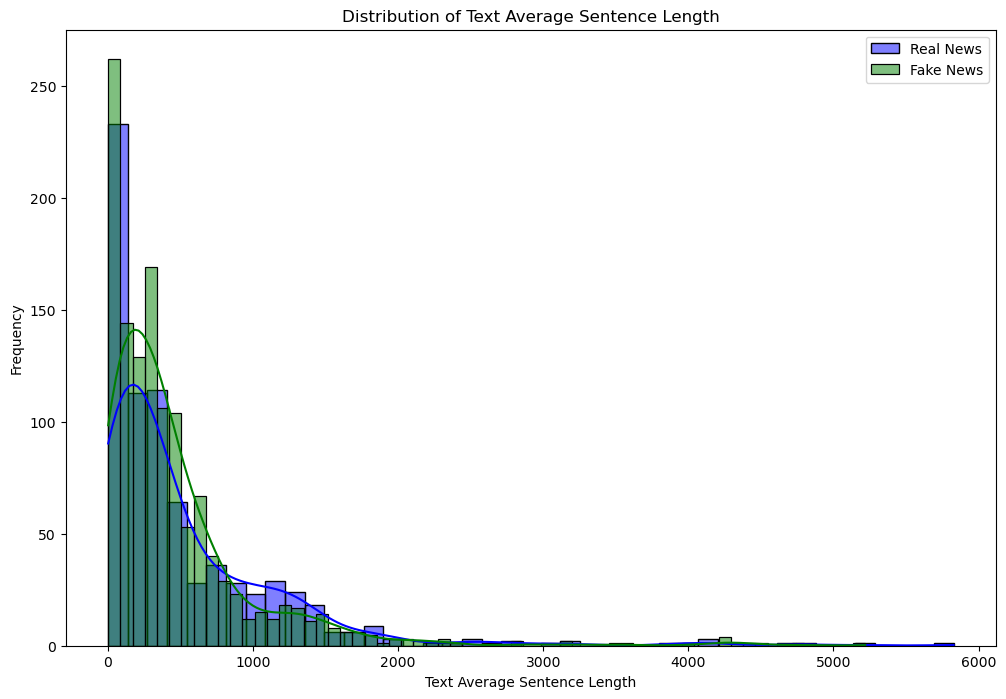

In [35]:
# 4.2 Distribution plots for significant metrics
for metric, name in significant_metrics[:6]:  # Just plot the top 4 significant metrics
    plt.figure(figsize=(12, 8))
    sns.histplot(real_news[metric].dropna(), kde=True, color="blue", alpha=0.5, label="Real News")
    sns.histplot(fake_news[metric].dropna(), kde=True, color="green", alpha=0.5, label="Fake News")
    plt.title(f'Distribution of {name}')
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


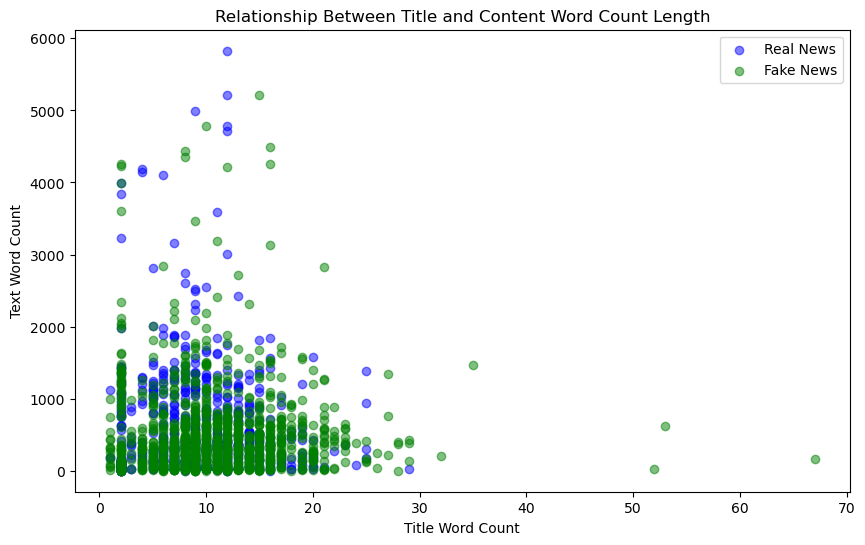

In [36]:
# 4.3 Scatter plot showing relationship between title length and content length
plt.figure(figsize=(10, 6))
plt.scatter(real_news['title_word_count'], real_news['text_word_count'], alpha=0.5, color='blue', label='Real News')
plt.scatter(fake_news['title_word_count'], fake_news['text_word_count'], alpha=0.5, color='green', label='Fake News')
plt.xlabel('Title Word Count')
plt.ylabel('Text Word Count')
plt.title('Relationship Between Title and Content Word Count Length')
plt.legend()
plt.show()

In [38]:
# 5. Normalization and Feature Engineering

# 5.1 Z-score normalization (Standard Scaling)
# This transforms features to have a mean of zero and a standard deviation of one
for metric, _ in metrics:
    z_score_column = f"{metric}_zscore"
    dataframe[z_score_column] = (dataframe[metric] - dataframe[metric].mean()) / dataframe[metric].std()

In [42]:
# 6. Save enhanced features to CSV with only significant metrics
print("\n--- Saving Enhanced Dataset with Significant Length Features ---")

# Select basic columns
basic_columns = ['author', 'title', 'text', 'site_url', 'label', 
               'enhanced_source_credibility_score', 'enhanced_author_credibility_score']

# Get list of significant metric column names
significant_metric_columns = [metric for metric, _ in significant_metrics]

# Get list of z-score columns for significant metrics
significant_metric_zscore_columns = [f"{metric}_zscore" for metric in significant_metric_columns]

# Combine all columns for the final dataset
final_columns = basic_columns + significant_metric_columns + significant_metric_zscore_columns

# Create new dataframe with selected columns
enhanced_dataframe = dataframe[final_columns]

# Save to CSV
enhanced_dataframe.to_csv('cleaned_dataset_with_credibility_and_significant_length_features.csv', index=False)


--- Saving Enhanced Dataset with Significant Length Features ---
